# generate_figures_main: reworked figures for merged manuscript

Includes additional filtering of genes with domain-level essentiality, updated color scheme and re-numbering of all figures to correspond to the order they appear in the final version of the merged manuscript (Couce et al + Limdi et al -> Couce, Limdi et al) 

## Goal of the notebook: integrate data on fitness effects with expression levels, structural variation to generate the figures for the paper

This is an updated version after the first rounds of reviews where we decided to shift focus purely from essentiality and broaden the scope of the analysis changes in fitness effects.

Input:
- data files in the folder Processed_data_for_plotting
- structural variation analysis (large deletions and duplicati
ons)
- gene expression levels (from Favate et al, eLife, 2022)

Output:
- panels for the figures for the paper.
- NOTE: I assemble the final figures with annotations in Illustrator.
- NOTE: Figures are not necessarily in the order they appear in the paper. I'll indicate exactly which figures I'm generating
- other data that goes into supplementary tables
- pvalues and statistical testing
- other summary statistics

#### NOTE: I have commented out all the places where I write images or data to file, please uncomment and rewrite data if you'd like to vary parameters and redo the analysis

In [22]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import re
from Bio.SeqIO.FastaIO import SimpleFastaParser
from matplotlib import cm
from statsmodels.stats.multitest import multipletests
import matplotlib.patches as mpatches
import os
from pathlib import Path

In [2]:
#current working directory
cwd = os.getcwd()
print(cwd)

/Users/anuraglimdi/Desktop/TnSeq_Paper/LTEE-TnSeq_Paper/Analysis/Part_3_TnSeq_analysis/Generate_figures


In [3]:
#use the pathlib.Path function to get the parent directories-> goal is to navigate to directory with the metadata
# and the breseq output data
path = Path(cwd)
repo = str(path.parents[2])
print(path.parents[2]) #this should be the base directory for the github repository: the exact path will differ for 
#each unique user

/Users/anuraglimdi/Desktop/TnSeq_Paper/LTEE-TnSeq_Paper


In [4]:
# sns.set_style('ticks')
sns.set_theme()
sns.set_context('paper')

### Paths from which I'm reading data/outputting the figure panels

In [5]:
figpath = repo +'/Analysis/Plots_for_paper/'
datapath = repo + '/Analysis/Part_3_TnSeq_analysis/Processed_data_for_plotting/'
metadata_path = repo +'/Metadata/'

In [6]:
#names of libraries
libraries = ['REL606', 'REL607', 'REL11330', 'REL11333', 'REL11364', 'REL11336', 'REL11339', 'REL11389', 'REL11392', 'REL11342', 'REL11345', 'REL11348', 'REL11367', 'REL11370']
#more interpretable names for the figures in the paper
libraries2 = ['Anc', 'Anc*', 'Ara–1', 'Ara–2', 'Ara–3', 'Ara–4', 'Ara–5', 'Ara–6', 'Ara+1', 'Ara+2', 'Ara+3', 'Ara+4', 'Ara+5', 'Ara+6']

In [413]:
#opening the pandas file with all the metadata!
all_data = pd.read_csv(metadata_path+"all_metadata_REL606.txt", sep="\t")

In [414]:
all_data.head()

,Gene Name,Locus Tag (prokka_output),Locus Tag (K12 reference),Start of Gene,End of Gene,Strand,UniProt ID,Protein Product
0,thrA,FJKNNBLA_00001,b0002,336,2798,1,P00561,fused aspartate kinase/homoserine dehydrogenase 1
1,thrB,FJKNNBLA_00002,b0003,2800,3732,1,P00547,homoserine kinase
2,thrC,FJKNNBLA_00003,b0004,3733,5019,1,P00934,threonine synthase
3,yaaX,FJKNNBLA_00004,b0005,5232,5528,1,P75616,DUF2502 domain-containing protein YaaX
4,yaaA,FJKNNBLA_00005,b0006,6457,5681,-1,P0A8I3,peroxide stress resistance protein YaaA


### Excluding genes that are known to be inconsistent between transposon sequencing datasets and deletion mutation libraries:

Goodall et al (https://journals.asm.org/doi/10.1128/mBio.02096-17) performed a tn-seq experiment of E. coli K-12 and compared it to the K-12 Keio collection, manually examining every gene found to be inconsistent. 

Their results show that there are many genes where only a specific (*sometimes quite small*) domain of the protein is required for function; insertions in the rest of the gene are completely tolerated, but a deletion is lethal. Because our approach of excluding the leading 10% and the final 25% of a gene isn't foolproof, I exclude from my analysis all of these genes with essentiality of specific domains only.

This list comprises of genes annotated as "Genes containing a transposon free region" in Supplementary Table 3 of Goodall et al (https://journals.asm.org/doi/10.1128/mBio.02096-17)

In [415]:
domain_essential = ['mqsA', 'waaU', 'yabQ', 'yafF', 
                    'yibJ', 'yqgD', 'ftsK', 'ftsN', 
                    'ftsX', 'lptC', 'ribB', 'rne',
                    'secM', 'spoT', 'yejM', 'polA']

In [420]:
domain_essential_index_original = all_data[all_data['Gene Name'].isin(domain_essential)].index
print(domain_essential_index_original)

Int64Index([86, 815, 999, 1952, 2579, 2694, 2713, 2861, 3108, 3297, 3512,
            3582],
           dtype='int64')


In [10]:
#removing the domain essential genes from our analysis
metadata = all_data[~all_data['Gene Name'].isin(domain_essential)]

In [11]:
names = metadata['Gene Name']
gene_start = metadata['Start of Gene']
gene_end = metadata['End of Gene']
strand = metadata['Strand']
locations = np.transpose(np.vstack([gene_start,gene_end,strand]))
k12_tags = metadata['Locus Tag (K12 reference)']
uniprot_rel606 = metadata['UniProt ID']
product = metadata['Protein Product']

In [12]:
#list of genes to be excluded from analysis as they lie within large deletions
exclude_genes = np.loadtxt(repo+"/Analysis/Part_2_WGS_analysis/output/Deleted_genes_REL606_k12annotated.txt")
exclude_pseudogenes = np.loadtxt(repo+"/Analysis/Part_2_WGS_analysis/output/Deleted_pseudogenes_REL606_k12annotated.txt")
locations_pseudogenes = np.loadtxt(metadata_path+'pseudogenes_locations_REL606.txt')
n_pseudo = exclude_pseudogenes.shape[1]

In [13]:
#fractions of the gene at the 5' and 3' ends to be excluded from analysis because they insertions there may not actually
#be disruptive to protein function
frac5p = 0.1
frac3p = 0.25

with open(metadata_path+"rel606_reference.fasta") as in_handle:
    for title, seq in SimpleFastaParser(in_handle):
        ta_sites = [m.start(0) for m in re.finditer('TA', seq)]
ta_sites = np.array(ta_sites)

#counting how many TA sites are present in each gene
ta_gene = np.zeros(len(names))
for i in range(0,len(names)):
    start = locations[i, 0]
    end = locations[i, 1]
    length = end - start
    #if the gene is on the forward strand
    if locations[i,2]==1:
        #counting sites only in the middle 80% of the gene, excluding 10% at each end
        ta_gene[i] = np.sum((ta_sites > start+length*frac5p)&(ta_sites < end - length*frac3p))
    elif locations[i,2]==-1:
        ta_gene[i] = np.sum((ta_sites < start+length*frac5p)&(ta_sites > end - length*frac3p))

In [14]:
#loading the fitness data files now:
fitness_gene_corrected = np.load(datapath+'/fitness_corrected_genes.npy')
fitness_gene_relaxed = np.load(datapath+'/fitness_genes_relaxed_thresholds_updated.npy')
fitness_pseudogene = np.load(datapath+'/fitness_pseudogenes.npy')
#these are all slightly different metrics of error
error_gene_inv = np.load(datapath+'/errors_genes_inv.npy')
error_pseudogene_inv = np.load(datapath+'/errors_pseudogenes_inv.npy')
error_gene_hybrid = np.load(datapath+'/errors_genes_hybrid.npy')
error_pseudogene_hybrid = np.load(datapath+'/errors_pseudogenes_hybrid.npy')

Filtering out the domain essential genes

In [15]:
fitness_gene_corrected = fitness_gene_corrected[metadata.index]
fitness_gene_relaxed = fitness_gene_relaxed[metadata.index]
error_gene_inv = error_gene_inv[metadata.index]
error_gene_hybrid = error_gene_hybrid[metadata.index]

In [16]:
exclude_genes = exclude_genes[:, metadata.index]

## Fig S2: Comparability of transposon libraries across strains

### Panel C

In [17]:
fraction_t0 = np.loadtxt(datapath+'fraction_t0_site_thresh_5_ta_min_5.txt')

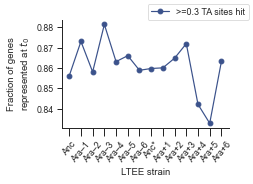

In [18]:
viridis = sns.color_palette('viridis', n_colors=3)
line = 0
order = [0,2,3,4,5,6,7,1,8,9,10,11,12,13]
with sns.axes_style('ticks'):
    fig,ax = plt.subplots(1,1,figsize=(3,2))
    for thresh in [0.3]:
        ax.plot(np.array(libraries2)[order], np.sum(fraction_t0[:,order]>=thresh, axis=0)/np.sum(fraction_t0[:,order]>-1,axis=0),'o-', color=viridis[line], label=f'>={thresh} TA sites hit')
        line+=1
    fig.legend(prop={'size': 9})
    ax.set_xlabel('LTEE strain')
    ax.set_ylabel('Fraction of genes\nrepresented at $t_{0}$')
#     ax.set_ylim(0.75,1)
    ax.tick_params(axis = 'x', size=8, rotation=50) 
    sns.despine()
#     plt.savefig(figpath+"fraction_genes_represented.pdf", format='pdf',bbox_inches='tight')

### Panel D

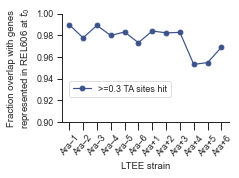

In [19]:
viridis = sns.color_palette('viridis', n_colors=3)
line = 0
order = [2,3,4,5,6,7,8,9,10,11,12,13]

thresh_vals = [0.3]
overlap = np.zeros([len(order),len(thresh_vals)])

for j in range(len(thresh_vals)):
    for k in order:
        overlap[k-2,j] = np.sum((fraction_t0[:,k]>=thresh_vals[j])&(fraction_t0[:,0]>=thresh_vals[j]))/np.sum((fraction_t0[:,0]>=thresh_vals[j])&(fraction_t0[:,k]!=-1))

with sns.axes_style('ticks'):
    fig,ax = plt.subplots(1,1,figsize=(3,2))
    for j in range(len(thresh_vals)):
        ax.plot(np.array(libraries2[2:]), overlap[:, j],'o-', color=viridis[line],label=f'>={thresh_vals[j]} TA sites hit')
        line+=1
    fig.legend(loc='center', prop={'size': 9})
    ax.set_xlabel('LTEE strain')
    ax.set_ylabel('Fraction overlap with genes\nrepresented in REL606 at $t_{0}$')
    ax.set_ylim(0.9,1)
    ax.tick_params(axis = 'x', size=8, rotation=50) 
    sns.despine()
#     plt.savefig(figpath+"gene_overlap_with_REL606.pdf", format='pdf',bbox_inches='tight')

## Fig S3: Fitness measurements are highly reproducible

### Panel A

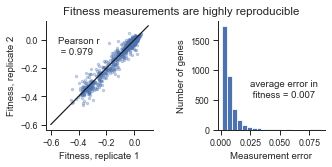

In [20]:
with sns.axes_style('ticks'):
    fig,ax = plt.subplots(1,2,figsize=(5,2))
    k = 8 #population: Ara+1
    genes_analyzed_noness = np.where((fitness_gene_corrected[:,k,0]>-1))[0]
    r_val = stats.pearsonr(fitness_gene_corrected[genes_analyzed_noness,k,0],fitness_gene_corrected[genes_analyzed_noness,k,1])
    ax[0].plot(fitness_gene_corrected[genes_analyzed_noness,k,0],fitness_gene_corrected[genes_analyzed_noness,k,1],'.', alpha=0.3)
    ax[0].plot(np.linspace(-0.6,0.1),np.linspace(-0.6,0.1),'k')
    ax[0].set(xlabel = 'Fitness, replicate 1', ylabel = 'Fitness, replicate 2')
    ax[0].set_ylabel('Fitness, replicate 2')
    ax[0].text(-0.55,  -0.1, f'Pearson r\n = {np.round(r_val[0],3)}')
    ax[1].hist(error_gene_inv[:,k][error_gene_inv[:,k]>-1],bins=20, color=sns.)
    ax[1].set(xlabel='Measurement error', ylabel='Number of genes')
    ax[1].text(0.025, 550, f'average error in \n fitness = {np.round(np.mean(error_gene_inv[:,k][error_gene_inv[:,k]>-1]),3)}')    
    sns.despine(offset=0)    
    plt.subplots_adjust(wspace=0.6)
    plt.suptitle("Fitness measurements are highly reproducible")
#     fig.savefig(figpath+"reproducibility_fitness.pdf", format='pdf',bbox_inches='tight')

## Fig S4: Excluding Ara-2 and Ara+4 from downstream analysis

### Panel A

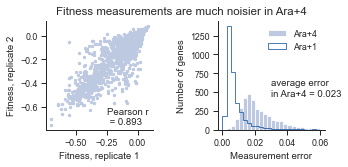

In [290]:
with sns.axes_style('ticks'):
    fig,ax = plt.subplots(1,2,figsize=(5,2))
    k = 11
    genes_analyzed_noness = np.where((fitness_gene_corrected[:,k,0]>-1))[0]
    r_val = stats.pearsonr(fitness_gene_corrected[genes_analyzed_noness,k,0],fitness_gene_corrected[genes_analyzed_noness,k,1])
    #subpanel 1
    ax[0].plot(fitness_gene_corrected[genes_analyzed_noness,k,0],fitness_gene_corrected[genes_analyzed_noness,k,1],'.',color=mpl.colors.hex2color('#bdc9e1'), alpha=1)
    ax[0].set(xlabel = 'Fitness, replicate 1', ylabel = 'Fitness, replicate 2')
    ax[0].set_ylabel('Fitness, replicate 2')
    ax[0].text(-0.25,  -0.75, f'Pearson r\n = {np.round(r_val[0],3)}')
    #subpanel 2
    ax[1].hist(error_gene_inv[:,k][error_gene_inv[:,k]>-1],bins=np.linspace(0,0.06,25), label='Ara+4',color=mpl.colors.hex2color('#bdc9e1'), alpha=1)
    ax[1].hist(error_gene_inv[:,8][error_gene_inv[:,8]>-1],bins=np.linspace(0,0.06,25), histtype='step', label='Ara+1',color=mpl.colors.hex2color('#225ea8'))
    ax[1].set(xlabel='Measurement error', ylabel='Number of genes')
    ax[1].legend(loc=0, frameon=False)
    ax[1].text(0.03, 450, f'average error \nin Ara+4 = {np.round(np.mean(error_gene_inv[:,k][error_gene_inv[:,k]>-1]),3)}')    
    
    sns.despine(offset=0)    
    plt.subplots_adjust(wspace=0.6)
    plt.suptitle("Fitness measurements are much noisier in Ara+4")
    fig.savefig(figpath+"not_reproducibility_fitness_araP4.png", format='png',bbox_inches='tight',dpi=600)

### Panel C

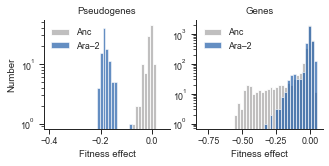

In [64]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1,2,figsize=(5,2))
    ax[1].hist(np.mean(fitness_gene_corrected[:,0,:],axis=1), bins=np.linspace(-0.8,0.05,40),label='Anc', color=mpl.colors.hex2color('#c0bfbf'))
    ax[1].hist(np.mean(fitness_gene_corrected[:,3,:],axis=1), bins=np.linspace(-0.8,0.05,40),alpha=0.7, label='Ara–2', color=mpl.colors.hex2color('#225ea8'))
    ax[1].set(xlabel='Fitness effect', title='Genes',yscale='log')
    ax[0].hist(np.mean(fitness_pseudogene[:,0,:],axis=1), bins=np.linspace(-0.4,0.05,40), label='Anc', color='#C0BFBF')
    ax[0].hist(np.mean(fitness_pseudogene[:,3,:],axis=1), bins=np.linspace(-0.4,0.05,40),alpha=0.7, label='Ara–2', color=mpl.colors.hex2color('#225ea8'))
    ax[0].set(xlabel='Fitness effect', ylabel='Number', title='Pseudogenes', yscale='log')
    ax[0].legend(loc='upper left',frameon=False)
    ax[1].legend(loc=0,frameon=False)

    # plt.subplots_adjust(wspace=0.6)
    sns.despine()
    plt.show()
    fig.savefig(figpath+'ara-2_exclusion.pdf',format='pdf',bbox_inches='tight')

## Figure 2: Distribution of fitness effects remains unchanged over evolution

In [65]:
#the dfe data pandas frame which is used for plotting a lot of the figure 2 panels
dfe_data = pd.read_csv(datapath+'/dfe_data_pandas.csv')

#renaming columns for purposes of the figure
dfe_data.rename(columns={'Fitness estimate':'Fitness effect'}, inplace=True)

For the plot, I'm going to reordering the populations: Anc-, Ara- populations, Anc+, Ara+ Populations

In [66]:
dfe_data_minus = dfe_data[(dfe_data['Ara Phenotype']=='Ara-')]
dfe_data_plus = dfe_data[(dfe_data['Ara Phenotype']=='Ara+')]
dfe_data = pd.concat([dfe_data_minus, dfe_data_plus])

Now, renaming the populations to be stylistically consistent with the companion paper.

In [67]:
pop_names_old = ['REL606', 'REL607', 'Ara-1', 'Ara-2', 'Ara-3', 'Ara-4', 'Ara-5', 'Ara-6', 'Ara+1', 'Ara+2', 'Ara+3', 'Ara+4', 'Ara+5', 'Ara+6']
for k in range(len(pop_names_old)):
    pop = pop_names_old[k]
    dfe_data.loc[(dfe_data['Population'] == pop)&(dfe_data['Mutator'] == 'non-mutator'), 'Population' ] = libraries2[k]
    dfe_data.loc[(dfe_data['Population'] == pop)&(dfe_data['Mutator'] == 'mutator'), 'Population' ] = libraries2[k]

In [68]:
dfe_data = dfe_data[~dfe_data['Population'].isin(['Ara–2', 'Ara+4'])]

### Panel B: Ridgeplot of near-neutral DFEs

In [69]:
sns.color_palette('deep')

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [317]:
ridgeplot_palette = []
k_reordered = [0,2,4,5,6,7,1,8,9,10,12,13]
for k in k_reordered:
    if k<2:
#         ridgeplot_palette.append(sns.color_palette('deep')[7])#gray

        ridgeplot_palette.append(mpl.colors.hex2color('#c0bfbf'))
#         ridgeplot_palette.append(sns.color_palette('deep')[0])#blue
    
#     elif k==3 or k==11: ###note, these are Ara-2 and Ara+4 which we want to exclude from our analysis
#         ridgeplot_palette.append(sns.color_palette('deep')[7])#gray
    else:
        ridgeplot_palette.append(mpl.colors.hex2color('#08519c'))
#         ridgeplot_palette.append(sns.color_palette('deep')[1])#orange

/Users/anuraglimdi/opt/miniconda3/envs/sns_env/lib/python3.10/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/anuraglimdi/opt/miniconda3/envs/sns_env/lib/python3.10/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/anuraglimdi/opt/miniconda3/envs/sns_env/lib/python3.10/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


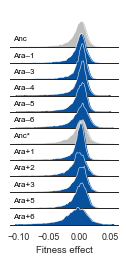

In [319]:
dfe_ridgeplot_inverse_var = dfe_data.loc[(dfe_data['Fitness effect']<0.05)&(dfe_data['Fitness effect']>-0.1)]

g = sns.FacetGrid(dfe_ridgeplot_inverse_var, row="Population",hue='Population',aspect=7, height=0.3, palette=ridgeplot_palette)
sns.set_theme(context="paper", rc={"axes.facecolor": (0, 0, 0, 0)},style='white')
g.map(sns.kdeplot, "Fitness effect",
      bw_adjust=.5, clip_on=True,
      fill=True, alpha=1, linewidth=1)
g.map(sns.kdeplot, "Fitness effect", clip_on=False, color="white", lw=0.5, bw_adjust=.25)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0.03, .2, label, color='black', size=8,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Fitness effect")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-0.6)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[],ylabel='')
g.set(xticks=[-0.1, -0.05, 0, 0.05])
g.despine(left=True)

g.savefig(figpath+'DFE_comparison_ridgeplot.pdf', format='pdf', bbox_inches='tight')

Run the above cell twice to get a nice looking plot

In [76]:
means_dfe = np.loadtxt(datapath+'/mean_dfe.txt')
var_dfe = np.loadtxt(datapath+'/variance_dfe.txt')
error_mean_inv = np.loadtxt(datapath+'/error_mean_inv.txt')
error_var_inv = np.loadtxt(datapath+'/error_variance_inv.txt')

I'm using the inverse variance weighted standard error estimates for Fig 2. See Methods for formulae on how they're calculated

#### Z-statistic calculation for whether means and variances differ

In [324]:
ridgeplot_palette_2 =  []
for k in range(len(libraries2)):
    if k<2:
        ridgeplot_palette_2.append(sns.color_palette('deep')[7])

#         ridgeplot_palette_2.append(mpl.colors.hex2color('#c0bfbf'))
#         ridgeplot_palette_2.append(sns.color_palette('deep')[0])
    elif k==3 or k==11: ###note, these are Ara-2 and Ara+4 which we want to exclude from our analysis
        ridgeplot_palette_2.append(sns.color_palette('deep')[7])
    else:
        ridgeplot_palette_2.append(mpl.colors.hex2color('#08519c'))
#         ridgeplot_palette_2.append(sns.color_palette('deep')[1])

In [325]:
n_comps = 10
for comp in [1,2,4,5,6,7,8,9,10,12,13]:
    anc_num = int((comp-1)/7) #comparing the ara+ populations against REL607
    z_test = (means_dfe[comp] - means_dfe[anc_num])/np.sqrt(error_mean_inv[comp]**2+error_mean_inv[anc_num]**2)
    #the bonferroni corrected p-value: multiply the raw p-values by 10: if they're less than 0.05, then significant
    print(libraries2[comp], '\tBonferroni corrected p value', np.round(stats.norm.sf(abs(z_test))*n_comps,5), '\tZ-statistic', np.round(z_test, 4))

Anc* 	Bonferroni corrected p value 1.45918 	Z-statistic -1.0541
Ara–1 	Bonferroni corrected p value 1.95528 	Z-statistic -0.8577
Ara–3 	Bonferroni corrected p value 0.0 	Z-statistic -6.8894
Ara–4 	Bonferroni corrected p value 3.72852 	Z-statistic 0.3243
Ara–5 	Bonferroni corrected p value 4.61052 	Z-statistic 0.0978
Ara–6 	Bonferroni corrected p value 0.00356 	Z-statistic 3.3847
Ara+1 	Bonferroni corrected p value 0.02964 	Z-statistic 2.7518
Ara+2 	Bonferroni corrected p value 3.88917 	Z-statistic -0.2821
Ara+3 	Bonferroni corrected p value 0.00272 	Z-statistic -3.4576
Ara+5 	Bonferroni corrected p value 4.357 	Z-statistic 0.1619
Ara+6 	Bonferroni corrected p value 0.0 	Z-statistic -6.4235


In [326]:
n_comps = 10
p_val = 0.05/n_comps
n_sd = stats.norm.ppf(p_val/2)  #note that we're doing a two tailed Z-test
order = [0,2,4,5,6,7,1,8,9,10,12,13]

### Panels C and D

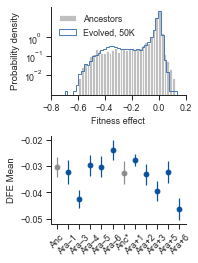

In [327]:
with sns.axes_style('ticks'):
    #2x2 grid
    bins=np.linspace(-0.8,0.2,50)
    fig, ax = plt.subplots(2,1, figsize=(2.85,3.75))

    #panel C: comparison of DFEs
    anc_data = np.reshape(np.mean(fitness_gene_corrected[:,[0,1],:],axis=2), newshape=len(names)*2)
    ax[0].hist(anc_data, density=1, bins=bins, histtype='bar', label='Ancestors', color=mpl.colors.hex2color('#c0bfbf'))
    evo_data = np.reshape(np.mean(fitness_gene_corrected[:,[2,4,5,6,7,8,9,10,12,13],:], axis=2), newshape=len(names)*10)
    ax[0].hist(evo_data, density=1, bins=bins,histtype='step', label='Evolved, 50K', color=mpl.colors.hex2color('#225ea8'))
    ax[0].legend(loc=2,frameon=False)
    ax[0].set_yscale('log')
    ax[0].set_xlim((-0.8,0.2))
    ax[0].set_yticks([10**-2, 10**-1, 1])

    ax[0].set_xlabel('Fitness effect', fontsize=9)
    ax[0].set_ylabel('Probability density')

    
    #panel D
    for pop in order:
        x = [libraries2[pop]]
        y = [means_dfe[pop]]        
        ax[1].errorbar(x,y, yerr = n_sd*error_mean_inv[pop],ecolor=ridgeplot_palette_2[pop])
        ax[1].plot(libraries2[pop], means_dfe[pop], 'o', c=ridgeplot_palette_2[pop])
#         ax[0,1].set_xticklabels([])
        ax[1].set_ylabel('DFE Mean')
    ax[1].tick_params(axis='x', which='both', labelrotation = 45)
    
    sns.despine()
#     fig.subplots_adjust(hspace=0.5)
    fig.tight_layout()
    fig.savefig(figpath+'fig2_DFE.pdf', format='pdf', bbox_inches='tight')

## Fig S6: Comparing means of the DFE after excluding s < -0.3

In [321]:
for comp in [1,2,4,5,6,7,8,9,10,12,13]:
    anc_num = int((comp-1)/7) #comparing the ara+ populations against REL607
    g_anc = np.where(np.mean(fitness_gene_corrected[:,anc_num,:],axis=1)>-0.3)[0]
    g_ev = np.where(np.mean(fitness_gene_corrected[:,comp,:],axis=1)>-0.3)[0]
    
    mu_anc = np.mean(fitness_gene_corrected[g_anc, anc_num, :])
    mu_ev = np.mean(fitness_gene_corrected[g_ev, comp, :])
    
    z_test = (mu_ev - mu_anc)/np.sqrt(error_mean_inv[comp]**2+error_mean_inv[anc_num]**2)
    
#     z_test = (means_dfe[comp] - means_dfe[anc_num])/np.sqrt(error_mean_inv[comp]**2+error_mean_inv[anc_num]**2)
    print(libraries2[comp], 'Bonferroni Corrected p value', np.round(stats.norm.sf(abs(z_test))*n_comps,5), 'Z-statistic', np.round(z_test, 4))

Anc* Bonferroni Corrected p value 3.76273 Z-statistic 0.3153
Ara–1 Bonferroni Corrected p value 2.05488 Z-statistic 0.8222
Ara–3 Bonferroni Corrected p value 0.48527 Z-statistic 1.6593
Ara–4 Bonferroni Corrected p value 0.45171 Z-statistic 1.6936
Ara–5 Bonferroni Corrected p value 3.39301 Z-statistic 0.4144
Ara–6 Bonferroni Corrected p value 0.3649 Z-statistic 1.793
Ara+1 Bonferroni Corrected p value 3.14286 Z-statistic -0.4837
Ara+2 Bonferroni Corrected p value 1.33854 Z-statistic -1.1084
Ara+3 Bonferroni Corrected p value 2.91755 Z-statistic -0.5483
Ara+5 Bonferroni Corrected p value 1.99737 Z-statistic 0.8426
Ara+6 Bonferroni Corrected p value 0.01447 Z-statistic -2.9787


In [322]:
mu_noness = np.zeros(len(libraries))
for k in range(len(libraries)):
    g = np.where(np.mean(fitness_gene_corrected[:,k,:],axis=1)>-0.3)[0]
    mu_noness[k] = np.mean(fitness_gene_corrected[g, k, :])

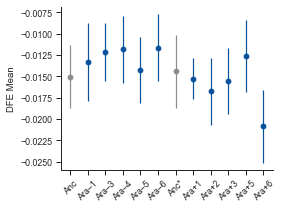

In [328]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(4,3))
    
    #panel C
    for pop in order:
        x = [libraries2[pop]]
        y = [mu_noness[pop]]        
        ax.errorbar(x,y, yerr = n_sd*error_mean_inv[pop],ecolor=ridgeplot_palette_2[pop])
        ax.plot(libraries2[pop], mu_noness[pop], 'o', c=ridgeplot_palette_2[pop])
#         ax[0,1].set_xticklabels([])
        ax.set_ylabel('DFE Mean')
    ax.tick_params(axis='x', which='both', labelrotation = 45)
    
    sns.despine()
#     fig.subplots_adjust(hspace=0.5)
    fig.tight_layout()
    fig.savefig(figpath+'mean_DFE_noness.pdf', format='pdf')

## Figure 3: Extensive and parallel changes in fitness effects

### Panel A

Pairwise comparison of fitness effects for ancestor vs each evolved population; marking significantly different genes

In [374]:
palette_delta_fe = [mpl.colors.hex2color('#542788'), mpl.colors.hex2color('#66AB55')]

In [375]:
pairwise_pops = [2,4,5,6,7,8,9,10,12,13]

73 42 REL11330
60 85 REL11364
51 61 REL11336
56 61 REL11339
70 39 REL11389
63 72 REL11392
49 58 REL11342
40 85 REL11345
60 50 REL11367
82 118 REL11370


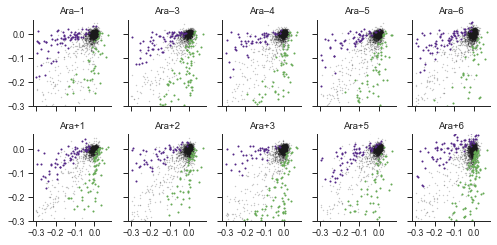

In [376]:
res_comps = np.zeros([3,10])
calculated = np.zeros([len(names), 10])
sig_diff = np.zeros([len(names), 10])
count=0

with sns.axes_style('ticks'):
    #2x2 grid
    fig, ax = plt.subplots(2,5, figsize=(7,3.5), sharey=True, sharex=True)
    for i, ax in enumerate(fig.axes):
        evo_pop = pairwise_pops[i]
        plot_volc = np.where((np.mean(fitness_gene_corrected[:,0,:],axis=1)>-0.3)&(np.mean(fitness_gene_corrected[:,evo_pop,:],axis=1)>-0.3))[0]
        fitness_anc = np.mean(fitness_gene_corrected[plot_volc,0,:],axis=1)
        fitness_evo = np.mean(fitness_gene_corrected[plot_volc,evo_pop,:],axis=1)
        diff = fitness_evo - fitness_anc
        meas_error = np.sqrt(error_gene_inv[plot_volc,0]**2+error_gene_inv[plot_volc,evo_pop]**2)
        pval_diff = stats.norm.sf(abs(diff/meas_error))*2
        significant1 = np.where((pval_diff<0.05/len(diff))&(diff>0))[0]
        significant2 = np.where((pval_diff<0.05/len(diff))&(diff<-0))[0]
        print(len(significant1), len(significant2), libraries[evo_pop])
        
        #storing this data on significant differences in another array (if needed later)
        calculated[plot_volc, count] = 1
        sig_diff[plot_volc[significant1], count] = 1    #more deleterious in the ancestor
        sig_diff[plot_volc[significant2], count] = -1    #more deleterious in the evolved
        
        ax.plot(fitness_anc, fitness_evo,'k.', alpha=0.3, markersize=0.7)
        ax.plot(fitness_anc[significant1], fitness_evo[significant1],'.', color=palette_delta_fe[0], markersize=2)
        ax.plot(fitness_anc[significant2], fitness_evo[significant2],'.', color=palette_delta_fe[1], markersize=2)

        #collecting results on number of differential fitness effects
        res_comps[0,count] = len(diff) - (len(significant1)+len(significant2))
        res_comps[1,count] = len(significant1)
        res_comps[2,count] = len(significant2)   
        count+=1

        ax.set_title(str(libraries2[pairwise_pops[i]]))
        ax.set_xticks([-0.3,-0.2,-0.1, 0])
        ax.set_yticks([-0.3,-0.2,-0.1, 0])
        ax.set_ylim(-0.3, 0.06)
#         ax.tick_params(axis='x', labelsize=8.5, rotation=45)
    
#     fig.text(0.44, -0.05, 'Fitness effect in Anc')
#     fig.text(0.04, 45, 'Fitness effect in evolved strain', rotate=90)
    

    sns.despine()
    fig.tight_layout()
    fig.savefig(figpath+'significant_fitness_effects.png', format='png', bbox_inches = 'tight', dpi=600)

### Panel B

Counting frequency of significantly different fitness effects

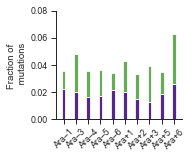

In [377]:
with sns.axes_style('ticks'):
    fig,ax = plt.subplots(figsize=(2.25,2))
    width=0.3
    labels_fig2e = ['Ara–1', 'Ara–3', 'Ara–4', 'Ara–5', 'Ara–6', 'Ara+1', 'Ara+2', 'Ara+3', 'Ara+5', 'Ara+6']
    ax.bar(labels_fig2e, res_comps[1,:]/np.sum(res_comps,axis=0), width, label='More deleterious in ancestor',
           color=palette_delta_fe[0])
    ax.bar(labels_fig2e, res_comps[2,:]/np.sum(res_comps,axis=0), width, bottom=res_comps[1,:]/np.sum(res_comps,axis=0),
           label='More deleterious in evolved', 
          color=palette_delta_fe[1])
    
#     ax.bar(labels_fig2e, res_comps[1,:], width, label='More deleterious in ancestor',
#            color=sns.mpl_palette('viridis',2)[0])
#     ax.bar(labels_fig2e, res_comps[2,:], width, bottom=res_comps[1,:],
#            label='More deleterious in evolved', 
#           color=sns.mpl_palette('viridis',2)[1])
    
    ax.set_ylabel('Fraction of \n mutations')
    # ax.set_title('Scores by group and gender')
#     ax.legend(prop={'size': 8}, frameon=False)
    ax.set(ylim=(0,0.08))
    ax.tick_params(axis='x', which='both', labelrotation = 45)
    sns.despine()
    fig.savefig(figpath+'freq_significant_fe.pdf', format='pdf', bbox_inches = 'tight')

Counting how many distinct genes have statistically significant fitness effects between the ancestor and at least one evolved population

In [357]:
np.sum(np.sum(sig_diff!=0, axis=1)>0)/np.sum(np.sum(calculated>0, axis=1)>0)

0.13021454112038142

Calculating p-values comparing means and variances of the different groups (anc vs evolved, mutator vs non-mutators)

In [358]:
pops_compare=[2,4,5,6,7,8,9,10,12,13]
#comparing means of ancestor and evolved populations, t-test
print('anc vs evolved, means')
print(stats.ttest_ind(means_dfe[:2], means_dfe[pops_compare], equal_var=False))

anc vs evolved, means
Ttest_indResult(statistic=0.9420039769220943, pvalue=0.37024282864174973)


#### Exploring parallelism in neutral to deleterious (and vice versa) transitions.

Defining a function which takes the fitness values, the thresholds for calling mutations as neutral/deleterious and returns an array with 1 if a gene has become neutral in that population and 2 if it has become deleterious in that population, relative to the ancestor

In [422]:
def neut_del_transitions(fitness, neutral, del_upper, del_lower, evol_compare = [2,4,5,6,7,8,9,10,12,13]):
    """
    Given thresholds for deleterious and neutral mutations, and fitness data
    Returns an array with 1 for genes that became neutral, 2 for genes that became deleterious
    0 indicates no large shift in fitness effect of mutation
    """
    
    #remove A-2 and A+4 from the analysis by default
    neut_del_data = np.zeros([len(names), len(evol_compare)])
    var = 0
    #iterating over all the populations we plan to analyze:
    for pop in evol_compare:
        anc_num = 0
        #extracting genes that are deleterious in ancestor and near neutral in the evolved population
        ess_anc = np.where((np.mean(fitness[:,anc_num,:],axis=1)<del_upper)& (np.mean(fitness[:,anc_num,:],axis=1)>del_lower)&(np.mean(fitness[:,pop,:],axis=1)>neutral)&(exclude_genes[pop,:]==0))[0]
        #extracting genes that are deleterious in the evolved population and near neutral in the ancestor
        ess_ev = np.where((np.mean(fitness[:,pop,:],axis=1)<del_upper)&(np.mean(fitness[:,pop,:],axis=1)>del_lower)&(np.mean(fitness[:,anc_num,:],axis=1)>neutral)&(exclude_genes[pop,:]==0))[0]
        neut_del_data[ess_anc, var] = 1
        neut_del_data[ess_ev, var] = 2
#         print(len(ess_anc), len(ess_ev))
        var+=1

    return neut_del_data

In [448]:
def plot_parallel_fe(neut_del_data, savepath=None, legend=None, title=None, neutral=None, del_upper=None, del_lower=None, 
                    evol_compare = [2,4,5,6,7,8,9,10,12,13], figsize=(3,2)):
    """
    Takes the neut/del data (array with 0,1,2)
    Generates a plot comparing the observed parallelism with expectation from randomness
    """
    
   #remove A-2 and A+4 from the analysis
    del_ev = np.sum(neut_del_data==2,axis=1)
    del_anc = np.sum(neut_del_data==1,axis=1)
    unique_del, counts_essev_del = np.unique(del_ev, return_counts=True)
    unique2_del, counts_essanc_del = np.unique(del_anc, return_counts=True)
    sims = 10**4
    results_del_anc = np.zeros(len(evol_compare)+1)
    results_del_ev = np.zeros(len(evol_compare)+1)

    #running the simulations
    for i in range(sims):
        #shuffle:
        shuffled_diff_essentiality = np.zeros([len(names),len(evol_compare)])
        #shuffling the data for each population:
        for k in range(0,len(evol_compare)):
            shuffled_diff_essentiality[:,k] = np.random.permutation(neut_del_data[:,k])

        shuffled_ess_ev = np.sum(shuffled_diff_essentiality==2,axis=1)
        shuffled_ess_anc = np.sum(shuffled_diff_essentiality==1,axis=1)
        unique_shuffled, counts_essev_shuffled = np.unique(shuffled_ess_ev, return_counts=True)
        unique2_shuffled, counts_essanc_shuffled = np.unique(shuffled_ess_anc, return_counts=True)
        results_del_anc[unique2_shuffled] += counts_essanc_shuffled
        results_del_ev[unique_shuffled] += counts_essev_shuffled
    
    with sns.axes_style('ticks'):
        fig, ax = plt.subplots(1,2, figsize=figsize, sharey=True)
        actual_ess = counts_essev_del[1:]
        simulated = results_del_ev[1:]/sims
        
        nonzeros = np.nonzero(simulated)[0]
        simulated = simulated[nonzeros]
        
        
        ax[0].plot(unique_del[1:], np.cumsum(actual_ess[::-1])[::-1] , color=palette_delta_fe[1], alpha=0.5)
        ax[0].plot(unique_del[1:], np.cumsum(actual_ess[::-1])[::-1] ,'^',label='Neutral -> Deleterious',color=palette_delta_fe[1])
        ax[0].plot(nonzeros+1, np.cumsum(simulated[::-1])[::-1] , color="black",alpha=0.5)
        ax[0].plot(nonzeros+1, np.cumsum(simulated[::-1])[::-1] , 'o',color="black")
        ax[0].set(ylabel='Number of genes\n with multiplicity >= $\it{m}$',
                 yscale='log', xticks = np.linspace(1,len(evol_compare),len(evol_compare)))

        actual_noness = counts_essanc_del[1:]
        simulated = results_del_anc[1:]/sims
        
        nonzeros = np.nonzero(simulated)[0]
        simulated = simulated[nonzeros]

        ax[1].plot(unique2_del[1:], np.cumsum(actual_noness[::-1])[::-1] ,color=palette_delta_fe[0], alpha=0.5)
        ax[1].plot(unique2_del[1:], np.cumsum(actual_noness[::-1])[::-1] ,'^',label='Deleterious -> Neutral',color=palette_delta_fe[0])
        ax[1].plot(nonzeros+1, np.cumsum(simulated[::-1])[::-1] , color="black",alpha=0.5)
        ax[1].plot(nonzeros+1, np.cumsum(simulated[::-1])[::-1] , 'o', color="black",label='Expectation due to chance')
        ax[1].set(yscale='log', xticks = np.linspace(1,len(evol_compare),len(evol_compare)))

        fig.text(0.12, -0.15, 'Multiplicity $\it{m}$: number of evolved clones \nwhere fitness effect changes')


        lines = []
        labels = []

        for ax in fig.axes:
            axLine, axLabel = ax.get_legend_handles_labels()
            lines.extend(axLine)
            labels.extend(axLabel)
        if legend:
            fig.legend(lines, labels,           
                   bbox_to_anchor=(1.4,0.8),ncol=1,frameon=False)

        if title:
            fig.suptitle(f'Params: neutral > {neutral}, deleterious $\in$ ({del_lower},{del_upper})')
        
        sns.despine(offset=0)
        
        if savepath:
            plt.savefig(savepath, format='pdf',bbox_inches = 'tight')

### Panel E 
Parallelism analysis of shifting fitness effects

In [208]:
neut_del_baseline = neut_del_transitions(fitness_gene_corrected, neutral=-0.05, del_upper=-0.15, del_lower=-0.3)

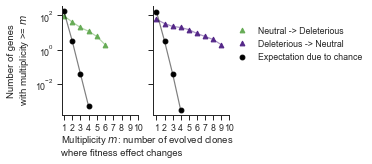

In [378]:
plot_parallel_fe(neut_del_baseline, savepath = figpath+ 'parallelism_fitness_effects.pdf', legend=True)
# plot_parallel_fe(neut_del_baseline, legend=True)

## Fig S5: Parallelism in fitness effect changes including Ara+4 and Ara-2

### Panel A

In [424]:
neut_del_baseline = neut_del_transitions(fitness_gene_corrected, neutral=-0.05, del_upper=-0.15,
                                         del_lower=-0.3, evol_compare=[2,3,4,5,6,7,8,9,10,11,12,13])

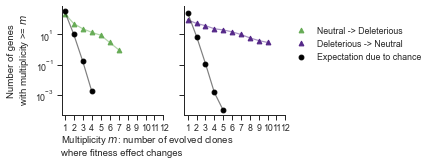

In [449]:
plot_parallel_fe(neut_del_baseline, savepath = figpath+ 'parallelism_fitness_effects_am2_ap4.pdf', legend=True, 
                evol_compare=[2,3,4,5,6,7,8,9,10,11,12,13], figsize=(4,2))


#### Making the clustered heatmaps for changing fitness effects (may be a supplementary figure)

NOTE: Genes that are not annotated (so they have a FJKNNBLA_xxxx) tag are excluded from analysis from here on.

Rationale: a part parallelism analysis is focused on the functional analysis; what roles do these proteins play in physiological processes? I wanted to exclude these genes with unknown functions/annotations just to keep things simple.

In [169]:
plot_ev = np.where(np.sum(neut_del_baseline==2, axis=1)>0)[0]
plot_anc = np.where((np.sum(neut_del_baseline==1, axis=1)>0))[0]

In [170]:
heatmap_pops = np.array([0,2,4,5,6,7,8,9,10,12,13])
cutoffs = np.ones(14)*-0.3

In [171]:
del_index = []
for index in range(len(plot_ev)):
    gene = plot_ev[index]
    if 'FJKNN' in names.iloc[gene]:## some genes are unknown and don't have a name assigned to them; excluding them from heatmap
        print(names.iloc[gene], gene)
        del_index.append(index)
        
plot_ev = np.delete(plot_ev, del_index)

FJKNNBLA_01375 1240


In [172]:
del_index = []
for index in range(len(plot_anc)):
    gene = plot_anc[index]
    if 'FJKN' in names.iloc[gene]:
        print(names.iloc[gene], gene)
        del_index.append(index)
        
plot_anc = np.delete(plot_anc, del_index)

FJKNNBLA_00753 655
FJKNNBLA_02052 1848


In [173]:
fitness_plot_ev = np.zeros([len(plot_ev), 11])
fitness_plot_anc = np.zeros([len(plot_anc), 11])
fitness_plot_ev2 = np.zeros([len(plot_ev), 11])
fitness_plot_anc2 = np.zeros([len(plot_anc), 11])

In [174]:
j = 0
for pop in heatmap_pops:
    #if a gene is essential under the relaxed criteria, then set the value to -0.3, which is the lowest
    fitness_plot_ev[:,j] = np.maximum(np.mean(fitness_gene_relaxed[plot_ev,pop,:],axis=1), cutoffs[pop])
    fitness_plot_anc[:,j] = np.maximum(np.mean(fitness_gene_relaxed[plot_anc,pop,:],axis=1), cutoffs[pop])
    fitness_plot_ev2[:,j] = np.maximum(np.mean(fitness_gene_relaxed[plot_ev,pop,:],axis=1), cutoffs[pop])
    fitness_plot_anc2[:,j] = np.maximum(np.mean(fitness_gene_relaxed[plot_anc,pop,:],axis=1), cutoffs[pop])
    j+=1

#if a gene is lost over evolution, exclude from analysis
for count in range(len(plot_ev)):
    gene = plot_ev[count]
    pops_lost = exclude_genes[heatmap_pops,gene] == 1
    #if a gene is lost setting it to 0 by default
    fitness_plot_ev[count,pops_lost] =  0
    fitness_plot_ev2[count,pops_lost] =  -0.4

#if a gene is lost over evolution, exclude from analysis
for count in range(len(plot_anc)):
    gene = plot_anc[count]
    pops_lost = exclude_genes[heatmap_pops,gene] == 1
    #if a gene is lost setting it to 0 by default
    fitness_plot_anc2[count,pops_lost] =  -0.4
    fitness_plot_anc[count,pops_lost] =  0

#### NOTE: For seaborn clustermap to work, there cannot be any NaNs in the data. 

This is annoying as I don't want to display genes that are lost over evolution the same way as the others.

Solution:
- use zero as a placeholder, do the agglomerative clustering, and then extract data on the order of genes.
- use seaborn heatmap with a custom colormap which indicates genes lost over evolution with a different color (for instance white)

In [175]:
sns_essentiality = pd.DataFrame(fitness_plot_ev, columns = np.array(libraries2)[heatmap_pops[:]], index = names.iloc[plot_ev])
sns_redundancy = pd.DataFrame(fitness_plot_anc, columns = np.array(libraries2)[heatmap_pops[:]], index = names.iloc[plot_anc])

In [176]:
names_label = []
for gene in names:
    names_label.append('$\it{'+ gene +'}$')
names_label = np.array(names_label)

In [177]:
sns_essentiality2 = pd.DataFrame(fitness_plot_ev2, columns = np.array(libraries2)[heatmap_pops[:]], index = names_label[plot_ev])
sns_redundancy2 = pd.DataFrame(fitness_plot_anc2, columns = np.array(libraries2)[heatmap_pops[:]], index = names_label[plot_anc])

In [178]:
from scipy.cluster.hierarchy import dendrogram, linkage

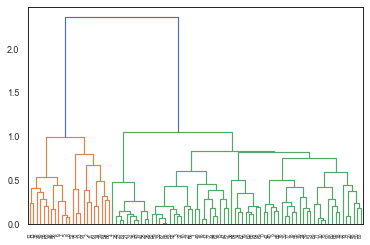

In [179]:
Z_ev = linkage(fitness_plot_ev, 'ward')

fig = plt.figure()
dn_ev = dendrogram(Z_ev)

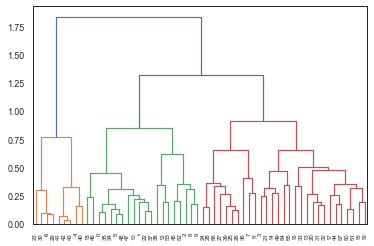

In [180]:
Z_anc = linkage(fitness_plot_anc, 'ward')
fig = plt.figure()
dn_anc = dendrogram(Z_anc)
# sns.despine()

In [181]:
print(len(dn_ev['ivl']),'Distinct genes becoming deleterious')
print(len(dn_anc['ivl']),'Distinct genes becoming neutral')

93 Distinct genes becoming deleterious
58 Distinct genes becoming neutral


#### What I'm doing in the following lines is to rearrange the genes in the order determined by the clustering algorithm. Then I plot this rearranged numpy array directly using the seaborn heatmap function.

What I do is to consider genes that are lost as having fitness = 0 for the purposes of clustering but highlight the genes as lost using a different assigned value plus custom colormap. 

This would not be possible in clustermap as the value used for clustering is what will be plotted, and there's no way to get around this, by having NaN for genes that are lost. 

If needed, I'll save the dendrogram separately and attach it to the heatmap in Illustrator.

In [182]:
sns_essentiality_test2 = sns_essentiality2.iloc[np.array(dn_ev['ivl']).astype('float'), :]
sns_redundancy_test2 = sns_redundancy2.iloc[np.array(dn_anc['ivl']).astype('float'), :]

In [183]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [202]:
color_num = 51
newcolors = np.zeros([51,4])


# viridis = cm.get_cmap('viridis', 121)

# newcolors = viridis(np.linspace(-1, 0.1, 121))
white = np.array([1,1,1,1])
# viridis = cm.get_cmap('RdGy', 41)
viridis = sns.color_palette("flare", as_cmap=True)
# viridis = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

newcolors[:1, :] = white
newcolors[10:, :] = viridis(np.linspace(0, 1, 41))

newcmp = ListedColormap(newcolors)

### Panel C

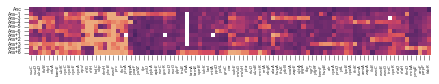

In [203]:
with sns.axes_style('ticks'):
    fig,ax = plt.subplots(figsize=(7.2,1.8))
    ax=sns.heatmap(sns_essentiality_test2.transpose(), cmap = newcmp, square=True
                   ,cbar_kws={'ticks': [0.0,-0.1,-0.2,-0.3], "shrink": 0.4, 'label':'Fitness effect'}
                  ,linecolor='white', vmax = np.max(fitness_plot_ev2),xticklabels=True, yticklabels=True,cbar=0)
    
#     ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xmajorticklabels(), fontsize = 5)
    
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 4, rotation = 90)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 5)
    ax.set_xlabel('')
    
#     fig.savefig(figpath+'heatmap_fitness_deleterious.pdf', format='pdf',bbox_inches='tight')

### Panel D

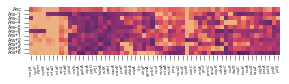

In [591]:
with sns.axes_style('ticks'):
    fig,ax = plt.subplots(figsize=(4.5,1.8))
    ax=sns.heatmap(sns_redundancy_test2.transpose(), cmap = cm.get_cmap('flare', 41), square=True, cbar_kws={'ticks': [0.0,-0.1,-0.2,-0.3], 'label':'Fitness effect'}
                  ,linecolor='white', vmax = np.max(fitness_plot_ev2),xticklabels=True, yticklabels=True,cbar=0)
    
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 4, rotation = 90)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 5)
    ax.set_xlabel('')

    
    fig.savefig(figpath+'heatmap_fitness_neutral.pdf', format='pdf',bbox_inches='tight')


## Fig S7: Parallelism in fitness effect changes is insensitive to thresholds 

In [281]:
#writing out six combinations for neutral, del_upper, del_lower
param1 = np.array([-0.05, -0.1, -0.3])
param2 = np.array([-0.05, -0.2, -0.3])
param3 = np.array([-0.05, -0.1, -0.2])
param4 = np.array([-0.05, -0.2, -0.4])
param5 = np.array([-0.1, -0.2, -0.3])
param6 = np.array([-0.025, -0.15, -0.3])
param_comb = np.array([param1, param2, param3, param4, param5, param6])

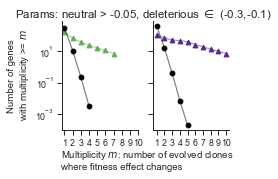

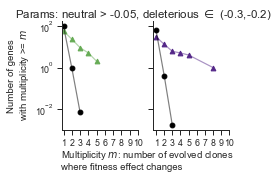

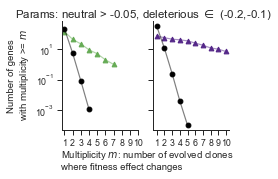

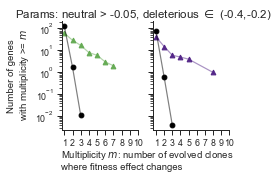

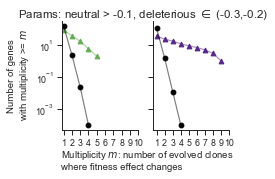

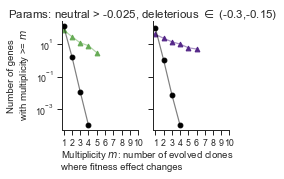

In [384]:
count = 1
for params in param_comb:
    neut_del_sens = neut_del_transitions(fitness_gene_corrected, neutral=params[0], del_upper=params[1], del_lower=params[2])
    plot_parallel_fe(neut_del_sens, title=True, savepath = figpath+f'params_{count}.pdf', neutral=params[0], del_upper=params[1], del_lower=params[2])
    count+=1

## Figure 4: Changes in essentiality

### Estimation of differential essentiality in DM25:
- $s_{gene}$ must be > -0.15 in strain 1, and $s_{gene|relaxed}$ in (-1,0.3) in strain 2: i.e. it should be highly deleterious/essential in strain 2, and fairly close to neutrality in strain 1
- max($s_{gene|relaxed}$) across the two replicates must be less than -0.2: Because the relaxed estimates may have higher errors, the mean may be quite off if one replicate is calculated as highly deleterious, but the other one is ~-0.15

In [147]:
diff_ess_DM25 = np.zeros([len(names), len(libraries)-1])
noness_DM25 = -0.15 #min fitness for considering a gene nonessential
ess_DM25 = -0.3 #max fitness for considering a gene essential

for k in range(1,len(libraries)):
    anc_num = 0
    ess_ev = np.where((np.mean(fitness_gene_corrected[:,anc_num,:], axis=1)>noness_DM25)&(np.mean(fitness_gene_relaxed[:,k,:], axis=1)<ess_DM25)&(np.max(fitness_gene_relaxed[:,k,:], axis=1)<ess_DM25+0.1)&(np.mean(fitness_gene_relaxed[:,k,:], axis=1)>-1)&(exclude_genes[k,:]==0))[0]
    ess_anc = np.where((np.mean(fitness_gene_corrected[:,k,:], axis=1)>noness_DM25)&(np.mean(fitness_gene_relaxed[:,0,:], axis=1)<ess_DM25)&(np.max(fitness_gene_relaxed[:,0,:], axis=1)<ess_DM25+0.1)&(np.mean(fitness_gene_relaxed[:,0,:], axis=1)>-1))[0]
    diff_ess_DM25[ess_ev, k-1] = 2
    diff_ess_DM25[ess_anc, k-1] = 1
    print(libraries[k], len(ess_anc), len(ess_ev))
#     print('based on fraction_t0', len(ess_anc2), len(ess_ev2))

REL607 0 0
REL11330 4 15
REL11333 99 0
REL11364 6 17
REL11336 5 7
REL11339 1 10
REL11389 37 5
REL11392 4 5
REL11342 7 10
REL11345 2 18
REL11348 6 85
REL11367 5 6
REL11370 3 16


### Estimation of differential essentiality in LB
If a gene has fitness above -0.15 in strain 1, but -1 in strain 2 even with relaxed thresholds, there are two possible reasons:
- gene is actually essential in LB in strain 2
- gene may not be essential strain 2, but we don't have enough info because the gene is too small or data is missing due to randomness

To distinguish these possibilities, I will do the following analysis:
- n1 = number of sites in gene in strain 1 that are above threshold
- n2 = number of sites in gene in strain 2 that are above threshold
- compute poisson.cdf(n1|mean=n2): basically, what is the probability of seeing less than or equal to n1 sites if the expected mean is n2? This should ideally help with filtering out genes where differences may be due to stochasticity and the small size of the gene

In [148]:
#fraction_t0 = fraction_t0[metadata.index]

IndexError: index 4005 is out of bounds for axis 0 with size 4005

In [137]:
diff_ess_LB = np.zeros([len(names), len(libraries)-1])
anc_absent = []

for k in range(1, len(libraries)):
    #genes that are calculated in the ancestor, but not in the evolved clone, even with relaxed thresholds
    ess_ev2 = np.where((np.mean(fitness_gene_corrected[:,anc_num,:], axis=1)>noness_DM25)&(np.abs(fraction_t0[:,k])<0.1)&(np.mean(fitness_gene_relaxed[:,k,:], axis=1)==-1)&(exclude_genes[k,:]==0))[0]
    count_ev = 0
    #genes that are calculated in the evolved clone, but not in the ancestor, even with relaxed thresholds
    ess_anc2 = np.where((np.mean(fitness_gene_corrected[:,k,:], axis=1)>noness_DM25)&(np.abs(fraction_t0[:,0])<0.1)&(np.mean(fitness_gene_relaxed[:,0,:], axis=1)==-1))[0]
    count_anc = 0
    
    #calculating the p-values assuming a stats.poisson distribution of how many sites are above a threshold
    pvals_ev = []
    for gene in ess_ev2:
        n_anc = fraction_t0[gene, anc_num]*ta_gene[gene]
        n_evo = fraction_t0[gene, k]*ta_gene[gene]
        pvals_ev.append(stats.poisson.cdf(n_evo, n_anc))
    
    pvals_anc = []
    for gene in ess_anc2:
        n_anc = fraction_t0[gene, anc_num]*ta_gene[gene]
        n_evo = fraction_t0[gene, k]*ta_gene[gene]
        pvals_anc.append(stats.poisson.cdf(n_anc, n_evo))
        
    #FDR correction: Benjamini Hochberg
    print(libraries[k])
    if pvals_ev!=[]:
        rejected,corrected_pvals,sidak,bonf = multipletests(pvals_ev, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
        print(np.sum(rejected==True), 'essential in LB in evo')
#         print(ess_ev2[rejected==True])
        diff_ess_LB[ess_ev2[rejected==True], k-1] = 2
        
    if pvals_anc!=[]:
        rejected,corrected_pvals,sidak,bonf = multipletests(pvals_anc, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
        print(np.sum(rejected==True),'essential in LB in anc')
#         print(ess_anc2[rejected==True])
        diff_ess_LB[ess_anc2[rejected==True], k-1] = 1
        ##tracking which genes are missing in the ANC transposon library by chance
        anc_absent += list(ess_anc2[np.where(rejected==False)[0]])
    
    print('\n')

REL607
0 essential in LB in evo
0 essential in LB in anc


REL11330
5 essential in LB in anc


REL11333
9 essential in LB in evo
11 essential in LB in anc


REL11364
5 essential in LB in evo
0 essential in LB in anc


REL11336
15 essential in LB in evo
6 essential in LB in anc


REL11339
4 essential in LB in evo
5 essential in LB in anc


REL11389
8 essential in LB in evo
29 essential in LB in anc


REL11392
8 essential in LB in evo
2 essential in LB in anc


REL11342
10 essential in LB in evo
9 essential in LB in anc


REL11345
3 essential in LB in evo
2 essential in LB in anc


REL11348
16 essential in LB in evo
5 essential in LB in anc


REL11367
13 essential in LB in evo
2 essential in LB in anc


REL11370
12 essential in LB in evo
6 essential in LB in anc




In [138]:
pops_include = [1,3,4,5,6,7,8,9,11,12]
libraries4 = ['ANC', 'ANC', 'Ara–1', 'Ara–3', 'Ara–4', 'Ara–5', 'Ara–6', 'Ara+1', 'Ara+2', 'Ara+3', 'Ara+5', 'Ara+6']
diff_ess_combined = diff_ess_DM25[:,pops_include] + diff_ess_LB[:,pops_include]

In [139]:
for k in range(0,len(pops_include)):
    print(libraries4[k+2], np.unique(diff_ess_combined[:,k], return_counts=1))

Ara–1 (array([0., 1., 2.]), array([3981,    9,   15]))
Ara–3 (array([0., 1., 2.]), array([3977,    6,   22]))
Ara–4 (array([0., 1., 2.]), array([3972,   11,   22]))
Ara–5 (array([0., 1., 2.]), array([3985,    6,   14]))
Ara–6 (array([0., 1., 2.]), array([3926,   66,   13]))
Ara+1 (array([0., 1., 2.]), array([3986,    6,   13]))
Ara+2 (array([0., 1., 2.]), array([3969,   16,   20]))
Ara+3 (array([0., 1., 2.]), array([3980,    4,   21]))
Ara+5 (array([0., 1., 2.]), array([3979,    7,   19]))
Ara+6 (array([0., 1., 2.]), array([3968,    9,   28]))


In [140]:
diff_data_total = diff_data = pd.DataFrame()
redundant = pd.DataFrame()
essential = pd.DataFrame()

redundant1 = np.sum(diff_ess_combined==1, axis=0)
essential1 = np.sum(diff_ess_combined==2, axis=0)
    
redundant["Number of changes"] = redundant1
redundant["Change in Essentiality"] = "Becomes nonessential over evolution"
redundant["Evolved Population"] = libraries4[2:]

essential["Number of changes"] = essential1
essential["Change in Essentiality"] = "Becomes essential over evolution"
essential["Evolved Population"] = libraries4[2:]

diff_data_total = diff_data_total.append(redundant, ignore_index=True)
diff_data_total = diff_data_total.append(essential, ignore_index=True)

/var/folders/f8/92wybs9d7wqfthlqj1drht_c0000gn/T/ipykernel_54376/1952534757.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff_data_total = diff_data_total.append(redundant, ignore_index=True)
/var/folders/f8/92wybs9d7wqfthlqj1drht_c0000gn/T/ipykernel_54376/1952534757.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff_data_total = diff_data_total.append(essential, ignore_index=True)


### Panel A

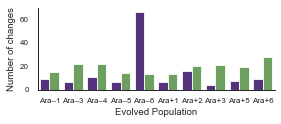

In [379]:
f, ax = plt.subplots(figsize=(4.25,1.5))
with sns.axes_style('ticks'):
    sns.barplot(x="Evolved Population", y="Number of changes", data=diff_data_total, hue='Change in Essentiality', palette=palette_delta_fe)
    # sns.barplot(x="Evolved Population", y="Number of Genes changing", data=diff_data_dm, hue='Change in Essentiality', palette=cm.Paired([3,1]), color="r")
    ax.legend_.remove()
    

    # add legend
    top_bar_1 = mpatches.Patch(color=palette_delta_fe[0], label='Essential -> Nonessential')
    # bottom_bar_1 = mpatches.Patch(color=cm.Paired(3), label='Essential in DM25 to \nNonessential in DM25')
    top_bar_2 = mpatches.Patch(color=palette_delta_fe[1], label='Nonessential -> Essential')
    top_bar_3 = mpatches.Patch(color=sns.color_palette('pastel')[7], label='Expectation due to chance')
    # bottom_bar_2 = mpatches.Patch(color=cm.Paired(1), label='Nonessential in DM25 to \nEssential in DM25')
    ax.tick_params(labelsize=8)
    sns.despine(offset=0)
    plt.savefig(figpath+'differential_essentiality_new.pdf', format='pdf', bbox_inches='tight')

In [527]:
print('number of essential-> nonessential changes vs nonessential -> essential changes')
stats.mannwhitneyu(np.sum(diff_ess_combined==2,axis=0), np.sum(diff_ess_combined==1,axis=0))

number of essential-> nonessential changes vs nonessential -> essential changes


MannwhitneyuResult(statistic=86.0, pvalue=0.007131559152918541)

## Fig S11: changes in essentiality partitioned by environment

In [143]:
diff_data_dm = pd.DataFrame()

redundant_dm = pd.DataFrame()
essential_dm = pd.DataFrame()

redundant1 = []
essential1 = []

for k in range(2,len(libraries)):
    if k not in [3,11]:
        redundant1.append(np.sum(diff_ess_DM25[:,k-1]==1))
        essential1.append(np.sum(diff_ess_DM25[:,k-1]==2))
    
redundant_dm["Number of changes"] = redundant1
redundant_dm["Change in Essentiality"] = "Becomes nonessential over evolution"
redundant_dm["Evolved Population"] = libraries4[2:]

essential_dm["Number of changes"] = essential1
essential_dm["Change in Essentiality"] = "Becomes essential over evolution"
essential_dm["Evolved Population"] = libraries4[2:]

diff_data_dm = diff_data_dm.append(redundant_dm, ignore_index=True)
diff_data_dm = diff_data_dm.append(essential_dm, ignore_index=True)

/var/folders/f8/92wybs9d7wqfthlqj1drht_c0000gn/T/ipykernel_54376/3171374192.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff_data_dm = diff_data_dm.append(redundant_dm, ignore_index=True)
/var/folders/f8/92wybs9d7wqfthlqj1drht_c0000gn/T/ipykernel_54376/3171374192.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff_data_dm = diff_data_dm.append(essential_dm, ignore_index=True)


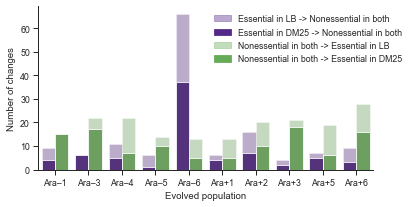

In [380]:
with sns.axes_style('ticks'):    
    f, ax = plt.subplots(figsize=(6, 3))
    sns.barplot(x="Evolved Population", y="Number of changes", data=diff_data_total, hue='Change in Essentiality', palette=palette_delta_fe, alpha=0.4)
    sns.barplot(x="Evolved Population", y="Number of changes", data=diff_data_dm, hue='Change in Essentiality', palette=palette_delta_fe, color="r")
    ax.legend_.remove()

    # add legend
    top_bar_1 = mpatches.Patch(color=palette_delta_fe[0],  alpha=0.4, label='Essential in LB -> Nonessential in both')
    bottom_bar_1 = mpatches.Patch(color=palette_delta_fe[0], label='Essential in DM25 -> Nonessential in both')
    top_bar_2 = mpatches.Patch(color=palette_delta_fe[1], alpha=0.4, label='Nonessential in both -> Essential in LB')
    bottom_bar_2 = mpatches.Patch(color=palette_delta_fe[1],  label='Nonessential in both -> Essential in DM25')

    plt.legend(handles=[top_bar_1,bottom_bar_1, top_bar_2, bottom_bar_2], bbox_to_anchor=(0.5,1),frameon=False)
    sns.despine(offset=0)
    ax.set_xlabel('Evolved population')
    
    plt.savefig(figpath+'differential_essentiality_media_new.pdf', format='pdf',bbox_inches='tight')

#### Parallelism in gene essentiality changes

In [150]:
ess_ev_combined = np.sum(diff_ess_combined==2,axis=1)
ess_anc_combined = np.sum(diff_ess_combined==1,axis=1)

In [151]:
unique_combined,counts_essev_combined = np.unique(ess_ev_combined, return_counts=True)
unique2_combined,counts_essanc_combined = np.unique(ess_anc_combined, return_counts=True)

In [166]:
sims = 10**4
results_essanc_combined = np.zeros(len(pops_include)+1)
results_essev_combined = np.zeros(len(pops_include)+1)

In [167]:
for i in range(sims):
    #shuffle:
    shuffled_diff_essentiality = np.zeros([len(names),len(pops_include)])
    #shuffling the data for each population:
    for k in range(0,len(pops_include)):
        shuffled_diff_essentiality[:,k] = np.random.permutation(diff_ess_combined[:,k])
    
    shuffled_ess_ev = np.sum(shuffled_diff_essentiality==2,axis=1)
    shuffled_ess_anc = np.sum(shuffled_diff_essentiality==1,axis=1)
    unique_shuffled, counts_essev_shuffled = np.unique(shuffled_ess_ev, return_counts=True)
    unique2_shuffled, counts_essanc_shuffled = np.unique(shuffled_ess_anc, return_counts=True)
    results_essanc_combined[unique2_shuffled] += counts_essanc_shuffled
    results_essev_combined[unique_shuffled] += counts_essev_shuffled

### Panel D

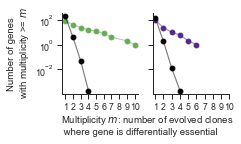

In [381]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1,2, figsize=(3,1.5),sharey=True)
    actual_ess = counts_essev_combined[1:]
    
    
    simulated = results_essev_combined[1:]/sims
    nonzeros = np.nonzero(simulated)[0]
    simulated = simulated[nonzeros]
    
    ax[0].plot(unique_combined[1:], np.cumsum(actual_ess[::-1])[::-1] , color=palette_delta_fe[1], alpha=0.5)
    ax[0].plot(unique_combined[1:], np.cumsum(actual_ess[::-1])[::-1] ,'o',label='Nonessential -> Essential',color=palette_delta_fe[1])
    ax[0].plot(nonzeros+1, np.cumsum(simulated[::-1])[::-1] , color="black",alpha=0.5)
    ax[0].plot(nonzeros+1, np.cumsum(simulated[::-1])[::-1] , 'o',color="black")
    ax[0].set(yscale='log', xticks = np.linspace(1,len(pops_include),len(pops_include)), ylabel='Number of genes\n with multiplicity >= $\it{m}$')
    actual_noness = counts_essanc_combined[1:]
    
    
    simulated = results_essanc_combined[1:]/sims
    nonzeros = np.nonzero(simulated)[0]
    simulated = simulated[nonzeros]
    
    ax[1].plot(unique2_combined[1:], np.cumsum(actual_noness[::-1])[::-1] ,color=palette_delta_fe[0], alpha=0.5)
    ax[1].plot(unique2_combined[1:], np.cumsum(actual_noness[::-1])[::-1] ,'o',label='Essential -> Nonessential',color=palette_delta_fe[0])
    ax[1].plot(nonzeros+1, np.cumsum(simulated[::-1])[::-1] , color="black",alpha=0.5)
    ax[1].plot(nonzeros+1, np.cumsum(simulated[::-1])[::-1] , 'o', color="black",label='Expectation due to chance')
    ax[1].set(yscale='log', xticks = np.linspace(1,len(pops_include),len(pops_include)))

    fig.text(0.12, -0.25, 'Multiplicity $\it{m}$: number of evolved clones\n where gene is differentially essential ')
    
    
    lines = []
    labels = []

    for ax in fig.axes:
        axLine, axLabel = ax.get_legend_handles_labels()
        lines.extend(axLine)
        labels.extend(axLabel)
        
#     fig.legend(lines, labels,           
           #bbox_to_anchor=(1.55,0.8),ncol=1,frameon=False)
    
    sns.despine(offset=0)
    
#     fig.savefig(figpath+'parallelism_diff_ess_with_legend.pdf', format='pdf',bbox_inches='tight')
    fig.savefig(figpath+'parallelism_essentiality.pdf', format='pdf',bbox_inches='tight')


## Fig S5: Parallelism in gene essentiality changes including Ara–2 and Ara+4

### Panel B

In [430]:
pops_include_am2_ap4 = [1,2,3,4,5,6,7,8,9,10,11,12]

In [431]:
libraries4_am2_ap4 = ['ANC', 'ANC', 'Ara–1', 'Ara–2', 'Ara–3', 'Ara–4', 'Ara–5', 'Ara–6', 'Ara+1', 'Ara+2', 'Ara+3', 'Ara+4', 'Ara+5', 'Ara+6']
diff_ess_combined_am2_ap4 = diff_ess_DM25[:,pops_include_am2_ap4] + diff_ess_LB[:,pops_include_am2_ap4]

In [432]:
ess_ev_combined_am2_ap4 = np.sum(diff_ess_combined_am2_ap4==2,axis=1)
ess_anc_combined_am2_ap4 = np.sum(diff_ess_combined_am2_ap4==1,axis=1)

In [433]:
unique_combined_am2_ap4,counts_essev_combined_am2_ap4 = np.unique(ess_ev_combined_am2_ap4, return_counts=True)
unique2_combined_am2_ap4,counts_essanc_combined_am2_ap4 = np.unique(ess_anc_combined_am2_ap4, return_counts=True)

In [434]:
sims = 10**4
results_essanc_combined_am2_ap4 = np.zeros(len(pops_include_am2_ap4)+1)
results_essev_combined_am2_ap4 = np.zeros(len(pops_include_am2_ap4)+1)

In [435]:
for i in range(sims):
    #shuffle:
    shuffled_diff_essentiality_am2_ap4 = np.zeros([len(names),len(pops_include_am2_ap4)])
    #shuffling the data for each population:
    for k in range(0,len(pops_include_am2_ap4)):
        shuffled_diff_essentiality_am2_ap4[:,k] = np.random.permutation(diff_ess_combined_am2_ap4[:,k])
    
    shuffled_ess_ev_am2_ap4 = np.sum(shuffled_diff_essentiality_am2_ap4==2,axis=1)
    shuffled_ess_anc_am2_ap4 = np.sum(shuffled_diff_essentiality_am2_ap4==1,axis=1)
    unique_shuffled_am2_ap4, counts_essev_shuffled_am2_ap4 = np.unique(shuffled_ess_ev_am2_ap4, return_counts=True)
    unique2_shuffled_am2_ap4, counts_essanc_shuffled_am2_ap4 = np.unique(shuffled_ess_anc_am2_ap4, return_counts=True)
    results_essanc_combined_am2_ap4[unique2_shuffled_am2_ap4] += counts_essanc_shuffled_am2_ap4
    results_essev_combined_am2_ap4[unique_shuffled_am2_ap4] += counts_essev_shuffled_am2_ap4

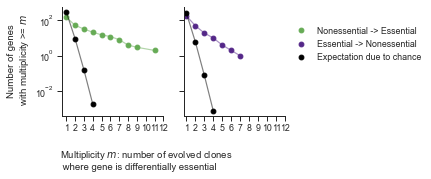

In [446]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1,2, figsize=(4,2),sharey=True)
    actual_ess = counts_essev_combined_am2_ap4[1:]
    
    
    simulated = results_essev_combined_am2_ap4[1:]/sims
    nonzeros = np.nonzero(simulated)[0]
    simulated = simulated[nonzeros]
    
    ax[0].plot(unique_combined_am2_ap4[1:], np.cumsum(actual_ess[::-1])[::-1] , color=palette_delta_fe[1], alpha=0.5)
    ax[0].plot(unique_combined_am2_ap4[1:], np.cumsum(actual_ess[::-1])[::-1] ,'o',label='Nonessential -> Essential',color=palette_delta_fe[1])
    ax[0].plot(nonzeros+1, np.cumsum(simulated[::-1])[::-1] , color="black",alpha=0.5)
    ax[0].plot(nonzeros+1, np.cumsum(simulated[::-1])[::-1] , 'o',color="black")
    ax[0].set(yscale='log', xticks = np.linspace(1,len(pops_include_am2_ap4),len(pops_include_am2_ap4)), ylabel='Number of genes\n with multiplicity >= $\it{m}$')
    
    
    actual_noness = counts_essanc_combined_am2_ap4[1:]
    simulated = results_essanc_combined_am2_ap4[1:]/sims
    nonzeros = np.nonzero(simulated)[0]
    simulated = simulated[nonzeros]
    
    ax[1].plot(unique2_combined_am2_ap4[1:], np.cumsum(actual_noness[::-1])[::-1] ,color=palette_delta_fe[0], alpha=0.5)
    ax[1].plot(unique2_combined_am2_ap4[1:], np.cumsum(actual_noness[::-1])[::-1] ,'o',label='Essential -> Nonessential',color=palette_delta_fe[0])
    ax[1].plot(nonzeros+1, np.cumsum(simulated[::-1])[::-1] , color="black",alpha=0.5)
    ax[1].plot(nonzeros+1, np.cumsum(simulated[::-1])[::-1] , 'o', color="black",label='Expectation due to chance')
    ax[1].set(yscale='log', xticks = np.linspace(1,len(pops_include_am2_ap4),len(pops_include_am2_ap4)))

    fig.text(0.12, -0.25, 'Multiplicity $\it{m}$: number of evolved clones\n where gene is differentially essential ')
    
    
    lines = []
    labels = []

    for ax in fig.axes:
        axLine, axLabel = ax.get_legend_handles_labels()
        lines.extend(axLine)
        labels.extend(axLabel)
        
    fig.legend(lines, labels,           
           bbox_to_anchor=(1.4,0.8),ncol=1,frameon=False)
    
    sns.despine(offset=0)
    
#     fig.savefig(figpath+'parallelism_diff_ess_with_legend.pdf', format='pdf',bbox_inches='tight')
    fig.savefig(figpath+'parallelism_essentiality_am2_ap4.pdf', format='pdf',bbox_inches='tight')


#### Clustered heatmap for changing gene essentiality

In [536]:
plot_ev = np.where(np.sum(diff_ess_combined==2, axis=1)>0)[0]
plot_anc = np.where((np.sum(diff_ess_combined==1, axis=1)>0))[0]

In [537]:
heatmap_pops = np.array([0,2,4,5,6,7,8,9,10,12,13])
cutoffs = np.ones(14)*-0.3

In [538]:
del_index = []
for index in range(len(plot_ev)):
    gene = plot_ev[index]
    if 'FJKNN' in names.iloc[gene]:## some genes are unknown and don't have a name assigned to them; excluding them from heatmap
        print(names.iloc[gene], gene)
        del_index.append(index)
        
plot_ev = np.delete(plot_ev, del_index)

FJKNNBLA_00385 346
FJKNNBLA_00765 665


In [539]:
del_index = []
for index in range(len(plot_anc)):
    gene = plot_anc[index]
    if 'FJKN' in names.iloc[gene]:
        print(names.iloc[gene], gene)
        del_index.append(index)
        
plot_anc = np.delete(plot_anc, del_index)

FJKNNBLA_02036 1834
FJKNNBLA_02056 1852


In [540]:
fitness_plot_ev = np.zeros([len(plot_ev), 11])
fitness_plot_anc = np.zeros([len(plot_anc), 11])
fitness_plot_ev2 = np.zeros([len(plot_ev), 11])
fitness_plot_anc2 = np.zeros([len(plot_anc), 11])

In [541]:
j = 0
for pop in heatmap_pops:
    #if a gene is essential under the relaxed criteria, then set the value to -0.3, which is the lowest
    fitness_plot_ev[:,j] = np.maximum(np.mean(fitness_gene_relaxed[plot_ev,pop,:],axis=1), cutoffs[pop])
    fitness_plot_anc[:,j] = np.maximum(np.mean(fitness_gene_relaxed[plot_anc,pop,:],axis=1), cutoffs[pop])
    fitness_plot_ev2[:,j] = np.maximum(np.mean(fitness_gene_relaxed[plot_ev,pop,:],axis=1), cutoffs[pop])
    fitness_plot_anc2[:,j] = np.maximum(np.mean(fitness_gene_relaxed[plot_anc,pop,:],axis=1), cutoffs[pop])
    j+=1

#if a gene is lost over evolution, exclude from analysis
for count in range(len(plot_ev)):
    gene = plot_ev[count]
    pops_lost = exclude_genes[heatmap_pops,gene] == 1
    #if a gene is lost setting it to 0 by default
    fitness_plot_ev[count,pops_lost] =  0
    fitness_plot_ev2[count,pops_lost] =  -0.4

#if a gene is lost over evolution, exclude from analysis
for count in range(len(plot_anc)):
    gene = plot_anc[count]
    pops_lost = exclude_genes[heatmap_pops,gene] == 1
    #if a gene is lost setting it to 0 by default
    fitness_plot_anc2[count,pops_lost] =  -0.4
    fitness_plot_anc[count,pops_lost] =  0

In [542]:
sns_essentiality = pd.DataFrame(fitness_plot_ev, columns = np.array(libraries2)[heatmap_pops[:]], index = names.iloc[plot_ev])
sns_redundancy = pd.DataFrame(fitness_plot_anc, columns = np.array(libraries2)[heatmap_pops[:]], index = names.iloc[plot_anc])

In [543]:
sns_essentiality2 = pd.DataFrame(fitness_plot_ev2, columns = np.array(libraries2)[heatmap_pops[:]], index = names_label[plot_ev])
sns_redundancy2 = pd.DataFrame(fitness_plot_anc2, columns = np.array(libraries2)[heatmap_pops[:]], index = names_label[plot_anc])

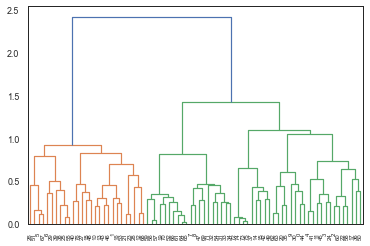

In [544]:
Z_ev = linkage(fitness_plot_ev, 'ward')

fig = plt.figure()
dn_ev = dendrogram(Z_ev)

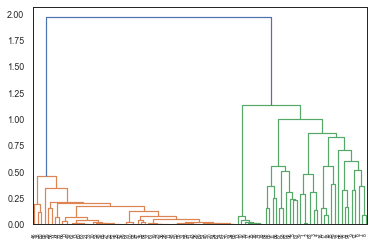

In [545]:
Z_anc = linkage(fitness_plot_anc, 'ward')
fig = plt.figure()
dn_anc = dendrogram(Z_anc)

In [546]:
print(len(dn_ev['ivl']),'Distinct genes becoming deleterious')
print(len(dn_anc['ivl']),'Distinct genes becoming neutral')

77 Distinct genes becoming deleterious
97 Distinct genes becoming neutral


In [547]:
sns_essentiality_test2 = sns_essentiality2.iloc[np.array(dn_ev['ivl']).astype('float'), :]
sns_redundancy_test2 = sns_redundancy2.iloc[np.array(dn_anc['ivl']).astype('float'), :]

## Figure 4: Parallel changes in gene essentiality

### Panel B

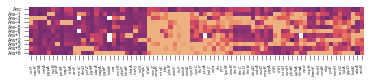

In [550]:
with sns.axes_style('ticks'):
    fig,ax = plt.subplots(figsize=(6,1.8))
    ax=sns.heatmap(sns_essentiality_test2.transpose(), cmap = newcmp, square=True
                   ,cbar_kws={'ticks': [0.0,-0.1,-0.2,-0.3], "shrink": 0.4, 'label':'Fitness effect'}
                  ,linecolor='white', vmax = np.max(fitness_plot_ev2),xticklabels=True, yticklabels=True,cbar=0)
    
#     ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xmajorticklabels(), fontsize = 5)
    
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 4, rotation = 90)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 5)
    ax.set_xlabel('')

    
    fig.savefig(figpath+'heatmap_fitness_essential_new.pdf', format='pdf',bbox_inches='tight')

### Panel C

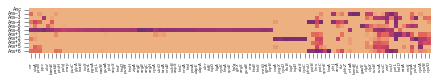

In [551]:
with sns.axes_style('ticks'):
    fig,ax = plt.subplots(figsize=(7.2,1.8))
    ax=sns.heatmap(sns_redundancy_test2.transpose(), cmap = cm.get_cmap('flare', 41), square=True, cbar_kws={'ticks': [0.0,-0.1,-0.2,-0.3], 'label':'Fitness effect'}
                  ,linecolor='white', vmax = np.max(fitness_plot_ev2),xticklabels=True, yticklabels=True,cbar=False)
    
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 4, rotation = 90)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 5)
    ax.set_xlabel('')
    
    fig.savefig(figpath+'heatmap_fitness_nonessential_new.pdf', format='pdf',bbox_inches='tight')


#### Exporting some legends for plots:

/var/folders/f8/92wybs9d7wqfthlqj1drht_c0000gn/T/ipykernel_54376/3193630427.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/f8/92wybs9d7wqfthlqj1drht_c0000gn/T/ipykernel_54376/3193630427.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figlegend.show()


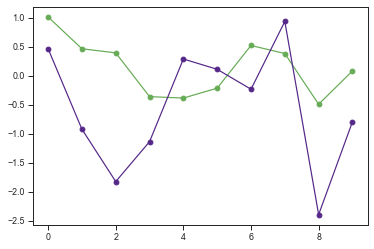

<Figure size 144x144 with 0 Axes>

In [382]:
import pylab

with sns.axes_style('ticks'):
    fig = pylab.figure()
    figlegend = pylab.figure(figsize=(2,2))
    ax = fig.add_subplot(111)
    ax.plot(range(10), pylab.randn(10), 'o-', color=palette_delta_fe[1], label='Nonessential -> Essential')
    ax.plot(range(10), pylab.randn(10), 'o-', color=palette_delta_fe[0], label='Essential -> Nonessential')
    
    figlegend.legend( ax.get_legend_handles_labels()[0], ax.get_legend_handles_labels()[1], 'center', ncol=1, frameon=False)
#     lines = ax.plot(range(10), pylab.randn(10), color=sns.mpl_palette('viridis',2)[0], range(10), pylab.randn(10),range(10), pylab.randn(10), range(10), pylab.randn(10))
#     figlegend.legend(lines, ('2 timepoints', '3 timepoints', '4 timepoints', '5 timepoints'), 'center', ncol=4)
    fig.show()
    figlegend.show()
    figlegend.savefig(figpath+'legend_fig3.pdf', format='pdf', bbox_inches='tight')

/var/folders/f8/92wybs9d7wqfthlqj1drht_c0000gn/T/ipykernel_54376/1732572431.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/f8/92wybs9d7wqfthlqj1drht_c0000gn/T/ipykernel_54376/1732572431.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figlegend.show()


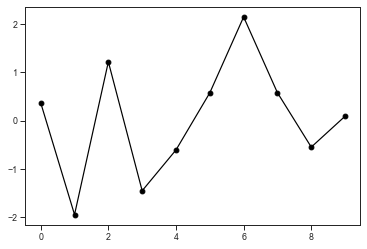

<Figure size 144x144 with 0 Axes>

In [383]:
with sns.axes_style('ticks'):
    fig = pylab.figure()
    figlegend = pylab.figure(figsize=(2,2))
    ax = fig.add_subplot(111)
    ax.plot(range(10), pylab.randn(10), 'o-', color='black', label='Expectation due to chance')
#     ax.plot(range(10), pylab.randn(10), 'o-', color=sns.mpl_palette('viridis',2)[0], label='Nonessential -> Essential')
    
    figlegend.legend( ax.get_legend_handles_labels()[0], ax.get_legend_handles_labels()[1], 'center', ncol=1, frameon=False)
#     lines = ax.plot(range(10), pylab.randn(10), color=sns.mpl_palette('viridis',2)[0], range(10), pylab.randn(10),range(10), pylab.randn(10), range(10), pylab.randn(10))
#     figlegend.legend(lines, ('2 timepoints', '3 timepoints', '4 timepoints', '5 timepoints'), 'center', ncol=4)
    fig.show()
    figlegend.show()
    figlegend.savefig(figpath+'legend_fig3_2.pdf', format='pdf', bbox_inches='tight')

### Counting the number of genes essential in the ancestral genome.

- Calculate number of genes with s < –0.3, even with relaxed thresholds
- For genes with s == -1, check if they're absent from the initial transposon library purely due to chance
- Exclude these from the set of putative essential genes.



In [627]:
anc_absent = list(set(anc_absent))

In [628]:
prelim_anc_essential = np.where(np.mean(fitness_gene_relaxed[:,0,:],axis=1)<-0.3)[0]

In [629]:
final_anc_essential = list(set(prelim_anc_essential) - set(anc_absent))

In [631]:
len(final_anc_essential)

557

## Fig S12: correlation between changes in gene expression and gene essentiality.

Note: we have not generated this gene expression data. It is from the following paper (which is very cool):
https://www.biorxiv.org/content/10.1101/2021.01.12.426406v1.full

In [385]:
expression_lvls = np.loadtxt(datapath+'expression_means.txt')
normalized_expression = expression_lvls/np.sum(expression_lvls,axis=0)*10**5

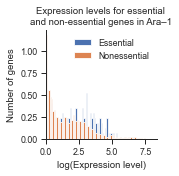

In [386]:
with sns.axes_style('ticks'):
    k = 2    
    bins=np.linspace(0,8,80)
    ess = np.where((np.mean(fitness_gene_relaxed[:,k],axis=1)>-1)&(np.mean(fitness_gene_relaxed[:,k],axis=1)<-0.3))[0]
    #getting indices of nonessential genes
    noness = np.where((np.mean(fitness_gene_corrected[:,k],axis=1)>-0.2))[0]
    fig,ax = plt.subplots(figsize=(2,2))
    ax.hist(np.log(1.01+ normalized_expression[ess,k]), label='Essential',bins=bins, density=1)
    ax.hist(np.log(1.01+ normalized_expression[noness,k]), label='Nonessential',bins=bins, density=1)
    ax.set(xlim=0, title=f'Expression levels for essential \nand non-essential genes in {libraries2[k]}',
          xlabel='log(Expression level)',ylabel='Number of genes')
    ax.legend(loc=0, frameon=False)
    sns.despine()
    plt.show()
#     fig.savefig(figpath+'expression_lvls.pdf', format='pdf', bbox_inches='tight')

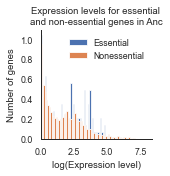

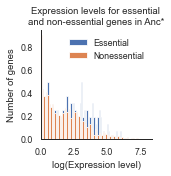

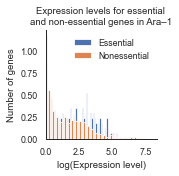

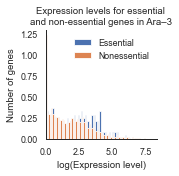

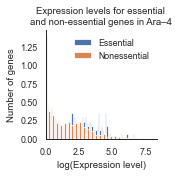

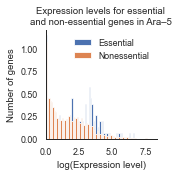

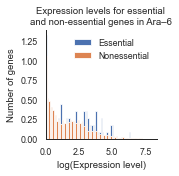

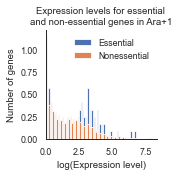

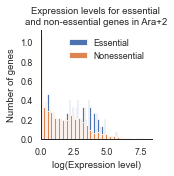

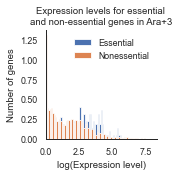

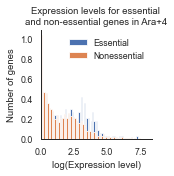

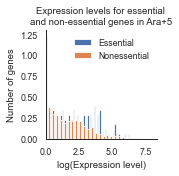

In [387]:
for k in [0,1,2,4,5,6,7,8,9,10,11,12]: 
    bins=np.linspace(0,8,80)
    ess = np.where((np.mean(fitness_gene_relaxed[:,k],axis=1)>-1)&(np.mean(fitness_gene_relaxed[:,k],axis=1)<-0.3))[0]
    #getting indices of nonessential genes
    noness = np.where((np.mean(fitness_gene_corrected[:,k],axis=1)>-0.2))[0]
    fig,ax = plt.subplots(figsize=(2,2))
    ax.hist(np.log(1.01+ normalized_expression[ess,k]), label='Essential',bins=bins,density=1)
    ax.hist(np.log(1.01+ normalized_expression[noness,k]), label='Nonessential',bins=bins,density=1)
    ax.set(xlim=0, title=f'Expression levels for essential \nand non-essential genes in {libraries2[k]}',
          xlabel='log(Expression level)',ylabel='Number of genes')
    ax.legend(loc=0, frameon=False)
    sns.despine()
    plt.show()

#### Overarching question: is change in gene essentiality linked to a corresponding change in gene expression?


In [388]:
anc_expression = []
evo_expression = []

count = 0
for pops in pops_include[:-1]:
    anc_ess = np.where(diff_ess_combined[:,count]==1)[0]

    for gene in anc_ess:
        anc_expression.append(float(normalized_expression[gene,0]))
        evo_expression.append(float(normalized_expression[gene,pops+1]))
    
    
    count+=1

In [390]:
anc_expression2 = []
evo_expression2 = []

count = 0
for pops in pops_include[:-1]:
    anc_ess = np.where(diff_ess_combined[:,count]==2)[0]

    for gene in anc_ess:
        anc_expression2.append(float(normalized_expression[gene,0]))
        evo_expression2.append(float(normalized_expression[gene,pops+1]))
    
    
    count+=1


In [391]:
expression_comparison = pd.DataFrame()

group1 = pd.DataFrame()
group2 = pd.DataFrame()
group3 = pd.DataFrame()
group4 = pd.DataFrame()

anc_expression = np.array(anc_expression)
evo_expression = np.array(evo_expression)
anc_expression2 = np.array(anc_expression2)
evo_expression2 = np.array(evo_expression2)


group1['log(Expression level)'] = np.log(anc_expression[anc_expression>-1]+1)
group1['Population'] = 'Ancestral'
group1[''] = 'Essential -> \nNonessential'

group2['log(Expression level)'] = np.log(evo_expression[evo_expression>-1]+1.0)
group2['Population'] = 'Evolved'
group2[''] = 'Essential -> \nNonessential'

group3['log(Expression level)'] = np.log(anc_expression2[anc_expression2>-1]+1)
group3['Population'] = 'Ancestral'
group3[''] = 'Nonessential -> \nEssential'

group4['log(Expression level)'] = np.log(evo_expression2[evo_expression2>-1]+1)
group4['Population'] = 'Evolved'
group4[''] = 'Nonessential -> \nEssential'

In [392]:
expression_comparison = expression_comparison.append(group1)
expression_comparison = expression_comparison.append(group2)
expression_comparison = expression_comparison.append(group3)
expression_comparison = expression_comparison.append(group4)

/var/folders/f8/92wybs9d7wqfthlqj1drht_c0000gn/T/ipykernel_54376/3789841112.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expression_comparison = expression_comparison.append(group1)
/var/folders/f8/92wybs9d7wqfthlqj1drht_c0000gn/T/ipykernel_54376/3789841112.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expression_comparison = expression_comparison.append(group2)
/var/folders/f8/92wybs9d7wqfthlqj1drht_c0000gn/T/ipykernel_54376/3789841112.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expression_comparison = expression_comparison.append(group3)
/var/folders/f8/92wybs9d7wqfthlqj1drht_c0000gn/T/ipykernel_54376/3789841112.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas

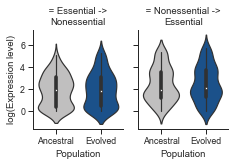

In [397]:
with sns.axes_style('ticks'):
    sns.set_palette(sns.color_palette(ridgeplot_palette[:2]))
    g = sns.catplot(x="Population", y="log(Expression level)", col="",
                    data=expression_comparison, kind="violin", split=False,
                    height=2.4, aspect=.7);
    g.savefig(figpath+'expression_diff_ess.pdf', format='pdf', bbox_inches='tight')